# Restricted Boltzmann Machine Defintion

In [43]:
# Import PyTorch library
import torch
import torch.nn as nn

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

In [75]:
# https://github.com/khanhnamle1994/MetaRec/blob/b5e36cb579a88b32cdfb728f35f645d76b24ad95/Boltzmann-Machines-Experiments/RBM-CF-PyTorch/rbm.py#L23
# Create the Restricted Boltzmann Machine architecture
class RBM(nn.Module):
    def __init__(self, n_vis, n_hid):
        """
        Initialize the parameters (weights and biases) we optimize during the training process
        :param n_vis: number of visible units
        :param n_hid: number of hidden units
        """
        self.i = 0

        # Weights used for the probability of the visible units given the hidden units
        super().__init__()
        self.W = torch.zeros(n_hid, n_vis, device=device)  # torch.rand: random normal distribution mean = 0, variance = 1

        # Bias probability of the visible units is activated, given the value of the hidden units (p_v_given_h)
        self.v_bias = torch.zeros(1, n_vis, device=device)  # fake dimension for the batch = 1

        # Bias probability of the hidden units is activated, given the value of the visible units (p_h_given_v)
        self.h_bias = torch.zeros(1, n_hid, device=device)  # fake dimension for the batch = 1
    
    def lr(self):
        return 0.02

    def sample_h(self, x):
        """
        Sample the hidden units
        :param x: the dataset
        """

        # Probability h is activated given that the value v is sigmoid(Wx + a)
        # torch.mm make the product of 2 tensors
        # W.t() take the transpose because W is used for the p_v_given_h
        wx = torch.mm(x, self.W.t())
        # print(wx.shape)

        # Expand the mini-batch
        activation = wx + self.h_bias.expand_as(wx)
        # print(activation.shape)

        # Calculate the probability p_h_given_v
        p_h_given_v = torch.sigmoid(activation)

        # print("h sparse", p_h_given_v.is_sparse, torch.bernoulli(p_h_given_v).is_sparse)

        # Construct a Bernoulli RBM to predict whether an user loves the movie or not (0 or 1)
        # This corresponds to whether the n_hid is activated or not activated
        return p_h_given_v, torch.bernoulli(p_h_given_v)

    def sample_v(self, y):
        """
        Sample the visible units
        :param y: the dataset
        """

        # Probability v is activated given that the value h is sigmoid(Wx + a)
        wy = torch.mm(y, self.W)

        # Expand the mini-batch
        activation = wy + self.v_bias.expand_as(wy)

        # Calculate the probability p_v_given_h
        p_v_given_h = torch.sigmoid(activation)

        # print("v sparse", p_v_given_h.is_sparse, torch.bernoulli(p_v_given_h).is_sparse)

        # Construct a Bernoulli RBM to predict whether an user loves the movie or not (0 or 1)
        # This corresponds to whether the n_vis is activated or not activated
        return p_v_given_h, torch.bernoulli(p_v_given_h)

    def train_model(self, v0, vk, ph0, phk):
        """
        Perform contrastive divergence algorithm to optimize the weights that minimize the energy
        This maximizes the log-likelihood of the model
        """

        w_extra = (torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)).t()
        v_extra = torch.sum((v0 - vk), 0)
        h_extra = torch.sum((ph0 - phk), 0)

        # if self.i % 45 == 0:
            # print(torch.max(w_extra), torch.max(v_extra), torch.max(h_extra), flush=True)

        # Approximate the gradients with the CD algorithm
        # TODO learning rate toevoegen
        self.W += self.lr() * w_extra

        # Add (difference, 0) for the tensor of 2 dimensions
        self.v_bias += self.lr() * v_extra
        self.h_bias += self.lr() * h_extra
        self.i += 1

In [45]:
cuda = torch.device('cuda')

# General Imports

In [46]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import gzip
import json
from tqdm import tqdm
import os
from collections import Counter
from datetime import datetime
import math
tqdm.pandas() #for progres_apply etc.

In [47]:
#read file line-by-line and parse json, returns dataframe
def parse_json(filename_gzipped_python_json, read_max=-1):
  #read gzipped content
  f=gzip.open(filename_gzipped_python_json,'r')
  
  #parse json
  parse_data = []
  for line in tqdm(f): #tqdm is for showing progress bar, always good when processing large amounts of data
    line = line.decode('utf-8')
    line = line.replace('true','True') #difference json/python
    line = line.replace('false','False')
    parsed_result = eval(line) #load python nested datastructure
    # print(filename_gzipped_python_json == steam_path + steam_reviews and 'user_id' not in parsed_result)
    # break
    if filename_gzipped_python_json == steam_path + steam_reviews and 'user_id' not in parsed_result:
      continue
      
    parse_data.append(parsed_result)
    if read_max !=-1 and len(parse_data) > read_max:
      print(f'Break reading after {read_max} records')
      break
  print(f"Reading {len(parse_data)} rows.")

  #create dataframe
  df= pd.DataFrame.from_dict(parse_data)
  return df

In [48]:
steam_path = './data/'
metadata_games = 'steam_games.json.gz' 
user_items = 'australian_users_items.json.gz'
user_reviews = 'australian_user_reviews.json.gz'
game_bundles = 'bundle_data.json.gz'
steam_reviews= 'steam_reviews.json.gz'

# Reading Australien Dataset

In [49]:

# for dataset in [metadata_games, user_items, user_reviews, game_bundles, steam_reviews]:
for dataset in [user_reviews]:
  print(f"----- {dataset}-----")
  size = os.path.getsize(steam_path + dataset) 
  print(f'Size of file is {size / 1000000}MB')
  df_metadata = parse_json(steam_path + dataset)
  pd.set_option('display.max_colwidth', None)
  # display(df_metadata.head(5))
#   display(df_metadata.describe(include='all'))

----- australian_user_reviews.json.gz-----
Size of file is 6.940139MB


25799it [00:01, 19842.73it/s]

Reading 25799 rows.


In [50]:
user_reviews_df = parse_json(steam_path + user_reviews)
user_reviews_df = user_reviews_df.drop_duplicates(subset='user_id')

25799it [00:01, 20071.30it/s]


Reading 25799 rows.


In [51]:
user_reviews_df_exploded = user_reviews_df.explode('reviews')
user_reviews_df_exploded = user_reviews_df_exploded.dropna()

In [52]:
def func(x):
    return x['recommend'], x["item_id"]

user_reviews_df_exploded['recommended'], user_reviews_df_exploded["item_id"] = zip(
    *user_reviews_df_exploded['reviews'].map(func)
)

In [53]:
user_reviews_df_exploded.reset_index()


user_reviews_df_exploded = user_reviews_df_exploded[['user_id', 'item_id', 'recommended']]

In [54]:
enkeltrue = user_reviews_df[['reviews']].apply(lambda x: [elem['recommend'] for elem in x['reviews']], axis=1)
enkeltrue.loc[enkeltrue.map(set).map(len) > 1]

24                         [False, True]
26       [True, True, True, False, True]
36                         [True, False]
60             [False, True, True, True]
71                         [False, True]
                      ...               
25758    [True, True, True, False, True]
25761                      [False, True]
25764                [True, True, False]
25768    [True, True, False, True, True]
25785                [True, True, False]
Length: 3684, dtype: object

In [55]:
dct = {}
def map_to_consecutive_id(uuid):
  if uuid in dct:
    return dct[uuid]
  else:
    id = len(dct)
    dct[uuid] = id
    return id
user_reviews_df_exploded['item_id_int'] = user_reviews_df_exploded['item_id'].progress_apply(map_to_consecutive_id)
user_reviews_df_exploded.dtypes
f = open("item_dct.json", 'w')
json.dump(dct, f)
f.close()

100%|██████████| 58430/58430 [00:00<00:00, 1327655.10it/s]


In [56]:
dct = {}
user_reviews_df_exploded['user_id_int'] = user_reviews_df_exploded['user_id'].progress_apply(map_to_consecutive_id)
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(user_reviews_df_exploded, test_size=0.2)


test_df_grouped = test_df.groupby('user_id_int').agg(list)
test_df_grouped = test_df_grouped.reset_index()

train_df_grouped = train_df.groupby('user_id_int').agg(list)
train_df_grouped = train_df_grouped.reset_index()


100%|██████████| 58430/58430 [00:00<00:00, 1269960.58it/s]


In [57]:
#Create scipy csr matrix
def get_sparse_matrix(df):
    shape = (user_reviews_df_exploded['user_id_int'].max() + 1, user_reviews_df_exploded['item_id_int'].max() + 1)
    
    user_ids = []
    item_ids = []
    values = []
    for idx, row in df.iterrows():
        items = row['item_id_int']
        user = row['user_id_int']
    
        recommended = row['recommended']
        user_ids.extend([user] * len(items))
        item_ids.extend(items)
        values.extend([2 if recommended[i] else 1 for i in range(len(items))])
    #create csr matrix
    # values = np.ones(len(user_ids))
    matrix = scipy.sparse.csr_matrix((values, (user_ids, item_ids)), shape=shape, dtype=np.int32)
    return matrix


In [58]:
test_matrix = get_sparse_matrix(test_df_grouped)

train_matrix = get_sparse_matrix(train_df_grouped)
train_matrix


<25457x3682 sparse matrix of type '<class 'numpy.intc'>'
	with 46744 stored elements in Compressed Sparse Row format>

In [73]:
torch.manual_seed(0)

-------
start training


100%|██████████| 100/100 [05:36<00:00,  3.36s/it]


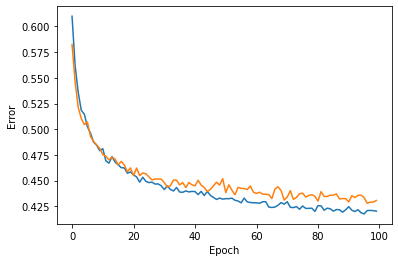

In [78]:
def score_model(rbm, batch_size):
    test_recon_error = 0  # RMSE reconstruction error initialized to 0 at the beginning of training
    s = 0  # a counter (float type) 
    # for loop - go through every single user
    for id_user in range(0, user_reviews_df_exploded['user_id_int'].max() + 1 - batch_size, batch_size):
        v = train_matrix[id_user:id_user + batch_size]  # training set inputs are used to activate neurons of my RBM
        vt = test_matrix[id_user:id_user + batch_size]  # target
        # v = convert_sparse_matrix_to_sparse_tensor(training_sample)
        # vt = convert_sparse_matrix_to_sparse_tensor(training_sample2)
        v = v.todense()
        vt = vt.todense()

        # v = v.to_dense()
        # vt = vt.to_dense()
        v = v - 1
        vt = vt - 1
        v = torch.Tensor(v)
        vt = torch.Tensor(vt)
        if torch.cuda.is_available():
            v = v.cuda()
            vt = vt.cuda()
        if len(vt[vt > -1]) > 0:
            _, h = rbm.sample_h(v)
            _, v = rbm.sample_v(h)

            # Update test RMSE reconstruction error
            test_recon_error += torch.sqrt(torch.mean((vt[vt > -1] - v[vt > -1])**2)) * len(vt > -1)
            s += len(vt > -1) 

    return test_recon_error / s

print('-------')
n_vis = user_reviews_df_exploded['item_id_int'].max() + 1
n_hidden = 1024
batch_size = 1024
epochs = 100
train_errors = []
test_errors = []
rbm = RBM(n_vis, n_hidden)

# https://stackoverflow.com/questions/40896157/scipy-sparse-csr-matrix-to-tensorflow-sparsetensor-mini-batch-gradient-descent
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()

    values = coo.data
    indices = np.vstack((coo.row, coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    # print(values)
    # print("values", v)
    shape = coo.shape
    tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape)) 
    if torch.cuda.is_available():
        tensor = tensor.cuda()

    return tensor 

print("start training")
for epoch in tqdm(range(epochs)):
    rbm.train()
    train_recon_error = 0  # RMSE reconstruction error initialized to 0 at the beginning of training
    s = 0
    
    for user_id in range(0, user_reviews_df_exploded['user_id_int'].max() + 1 - batch_size, batch_size):
        training_sample = train_matrix[user_id : user_id + batch_size]
        training_sample2 = train_matrix[user_id : user_id + batch_size]
        # print(training_sample)
        v0 = convert_sparse_matrix_to_sparse_tensor(training_sample)
        # print(v0.coalesce().indices())
        vk = convert_sparse_matrix_to_sparse_tensor(training_sample2)

        v0 = v0.to_dense()
        vk = vk.to_dense()
        v0 = v0.sub(1)
        vk = vk.sub(1)
        
        ph0, _ = rbm.sample_h(v0)   

        # Third for loop - perform contrastive divergence
        # TODO misschien is iets lager proberen?
        for k in range(10):
            _, hk = rbm.sample_h(vk)
            _, vk = rbm.sample_v(hk)

            # We don't want to learn when there is no rating by the user, and there is no update when rating = -1
            # Remove indices from vk vector that are not in the v0 vector => get sparse tensor again
            vk[v0 < 0] = v0[v0 < 0]
            vksparse = vk.to_sparse()
            # print("v0", v0)
            # print("v0", v0.add(1).to_sparse())
            # print("vk", vk.add(1).to_sparse())
            
            # print(k)

        phk, _ = rbm.sample_h(vk)


        rbm.train_model(v0, vk, ph0, phk)
        
        train_recon_error += torch.sqrt(torch.mean((v0[v0 > -1] - vk[v0 > -1])**2)) * len(v0 > -1)
        s += len(v0 > -1)
        
        # print((torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)).t().shape)
        # print(torch.sum((-vk + v0), 0).shape)
        # print(torch.sum((ph0 - phk), 0).shape)
        
    train_errors.append(train_recon_error / s)

    # print('calculating test scores')
    rbm.eval()
    test_errors.append(score_model(rbm, batch_size))

    # print('finished epoch', epoch)    
    
import matplotlib.pyplot as plt
# Plot the RMSE reconstruction error with respect to increasing number of epochs
plt.plot(torch.Tensor(train_errors, device='cpu'), label="train")
plt.plot(torch.Tensor(test_errors, device='cpu'), label="test")
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.savefig(f'test0-{batch_size}-{epochs}.jpg')

# Evaluate the RBM on test set
# test_recon_error = score_model(rbm)
# print("Final error", test_recon_error)
        

In [ ]:
plt.plot(torch.Tensor(train_errors, device='cpu'), label="train")
plt.plot(torch.Tensor(test_errors, device='cpu'), label="test")
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.savefig('errors.jpg')

In [ ]:
# torch.save(rbm.state_dict(), "./network")

In [ ]:
rbm = RBM(n_vis, n_hidden)
rbm.load_state_dict(torch.load("./network"))
rbm.eval()

# Reading Full Dataset

In [22]:
steam_reviews_df = parse_json(steam_path + steam_reviews)
steam_reviews_df_small = steam_reviews_df[['user_id', 'product_id', 'recommended', 'date']]

7793069it [03:55, 33126.20it/s]


Reading 3176223 rows.


In [23]:
steam_reviews_df_cleaned = steam_reviews_df_small.dropna(axis=0, subset=['user_id'])

In [24]:
steam_reviews_df_cleaned.head(5)
steam_reviews_df["user_id"].value_counts(dropna=False)

76561198011965365    1254
76561198094803808     900
76561197969749884     750
76561198094321628     669
76561198073092169     549
                     ... 
76561198345086561       1
76561198054491833       1
76561198095690287       1
76561198301658414       1
76561198089897928       1
Name: user_id, Length: 1485611, dtype: int64

In [25]:
dct = {}
def map_to_consecutive_id(uuid):
  if uuid in dct:
    return dct[uuid]
  else:
    id = len(dct)
    dct[uuid] = id
    return id
steam_reviews_df_cleaned['product_id_int'] = steam_reviews_df_cleaned['product_id'].progress_apply(map_to_consecutive_id)

100%|██████████| 3176223/3176223 [00:02<00:00, 1579855.53it/s]


## Random Split

In [26]:
# from sklearn.model_selection import train_test_split
# train_df, test_df = train_test_split(steam_reviews_df_cleaned, test_size=0.2)


# test_df_grouped = test_df.groupby('user_id_int').agg(list)
# test_df_grouped = test_df_grouped.reset_index()

# train_df_grouped = train_df.groupby('user_id_int').agg(list)
# train_df_grouped = train_df_grouped.reset_index()

## Date Split

In [80]:
steam_reviews_df_cleaned["date"] = pd.to_datetime(steam_reviews_df_cleaned["date"])
display(steam_reviews_df_cleaned.dtypes)
display(steam_reviews_df_cleaned.head(5))


user_id                   object
product_id                object
recommended                 bool
date              datetime64[ns]
product_id_int             int64
dtype: object

,user_id,product_id,recommended,date,product_id_int
0,76561198007483075,35140,True,2018-01-04,0
1,76561197970402776,707610,True,2017-10-16,1
2,76561198060686749,328100,True,2017-06-23,2
3,76561198023491401,35140,True,2018-01-03,0
4,76561198115331805,35140,True,2018-01-03,0


In [81]:
steam_reviews_df_grouped = steam_reviews_df_cleaned.groupby("user_id")[["product_id_int", "recommended", "date"]].agg(list)
display(steam_reviews_df_grouped.head(5))

steam_reviews_df_grouped_smaller = steam_reviews_df_grouped[steam_reviews_df_grouped["recommended"].map(len) > 1]
display(steam_reviews_df_grouped_smaller.head(5))


,product_id_int,recommended,date
user_id,,,
76561197960265806,[14313],[True],[2017-12-20 00:00:00]
76561197960266010,[9722],[True],[2017-11-27 00:00:00]
76561197960266146,[597],[True],[2017-11-04 00:00:00]
76561197960266225,[1622],[True],[2017-06-07 00:00:00]
76561197960266375,[3716],[True],[2017-09-13 00:00:00]


,product_id_int,recommended,date
user_id,,,
76561197960266546,"[2678, 2678]","[True, True]","[2016-11-25 00:00:00, 2016-11-25 00:00:00]"
76561197960266564,"[7259, 7259]","[True, True]","[2016-08-14 00:00:00, 2016-08-14 00:00:00]"
76561197960267022,"[7779, 13382]","[True, True]","[2015-09-29 00:00:00, 2015-04-16 00:00:00]"
76561197960267615,"[1428, 2098, 2545, 2643, 2633, 3052, 3150, 3979, 3979, 5255, 5797, 5747, 5884, 6832, 6500, 6956, 7122, 7102, 7352, 7469, 7931, 9757, 9911, 10291, 11006, 11309, 11432, 11736, 12754, 12703, 12755, 13323, 13215, 13544, 14085, 14055]","[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]","[2012-11-06 00:00:00, 2011-11-30 00:00:00, 2011-07-16 00:00:00, 2011-11-30 00:00:00, 2012-04-04 00:00:00, 2011-07-06 00:00:00, 2011-11-30 00:00:00, 2010-12-10 00:00:00, 2010-12-10 00:00:00, 2011-11-30 00:00:00, 2010-12-10 00:00:00, 2011-11-30 00:00:00, 2013-01-09 00:00:00, 2011-11-30 00:00:00, 2013-10-30 00:00:00, 2011-11-30 00:00:00, 2011-11-30 00:00:00, 2011-11-30 00:00:00, 2011-11-30 00:00:00, 2011-11-30 00:00:00, 2011-11-30 00:00:00, 2010-12-10 00:00:00, 2011-09-13 00:00:00, 2010-12-10 00:00:00, 2011-11-30 00:00:00, 2012-11-05 00:00:00, 2011-11-30 00:00:00, 2011-07-20 00:00:00, 2012-12-14 00:00:00, 2011-11-30 00:00:00, 2011-11-30 00:00:00, 2010-12-10 00:00:00, 2011-11-30 00:00:00, 2012-07-14 00:00:00, 2011-07-30 00:00:00, 2011-11-30 00:00:00]"
76561197960268226,"[9485, 13462]","[True, True]","[2015-06-01 00:00:00, 2016-11-28 00:00:00]"


In [82]:
dct.clear()
steam_reviews_df_grouped_smaller = steam_reviews_df_grouped_smaller.reset_index()
steam_reviews_df_grouped_smaller["user_id_int"] = steam_reviews_df_grouped_smaller["user_id"].progress_apply(map_to_consecutive_id)

100%|██████████| 581343/581343 [00:00<00:00, 1062545.44it/s]


In [83]:
display(steam_reviews_df_grouped_smaller.shape)
display(steam_reviews_df_grouped.shape)
print(steam_reviews_df_grouped.shape[0] - steam_reviews_df_grouped_smaller.shape[0])

(581343, 5)

(1485611, 3)

904268


In [84]:

def split(items, train_percentage):
    train_count = math.floor(len(items) * train_percentage)
    return items[0:train_count], items[train_count:]

train_percentage = 0.8
steam_reviews_df_grouped_smaller["product_history"] = steam_reviews_df_grouped_smaller["product_id_int"].progress_apply(lambda items: split(items, train_percentage)[0])
steam_reviews_df_grouped_smaller["product_future"] = steam_reviews_df_grouped_smaller["product_id_int"].progress_apply(lambda items: split(items, train_percentage)[1])
steam_reviews_df_grouped_smaller["recommended_history"] = steam_reviews_df_grouped_smaller["recommended"].progress_apply(lambda items: split(items, train_percentage)[0])
steam_reviews_df_grouped_smaller["recommended_future"] = steam_reviews_df_grouped_smaller["recommended"].progress_apply(lambda items: split(items, train_percentage)[1])
display(steam_reviews_df_grouped_smaller.head(5))

100%|██████████| 581343/581343 [00:00<00:00, 1080321.69it/s]


,user_id,product_id_int,recommended,date,user_id_int,product_history,product_future,recommended_history,recommended_future
0,76561197960266546,"[2678, 2678]","[True, True]","[2016-11-25 00:00:00, 2016-11-25 00:00:00]",0,[2678],[2678],[True],[True]
1,76561197960266564,"[7259, 7259]","[True, True]","[2016-08-14 00:00:00, 2016-08-14 00:00:00]",1,[7259],[7259],[True],[True]
2,76561197960267022,"[7779, 13382]","[True, True]","[2015-09-29 00:00:00, 2015-04-16 00:00:00]",2,[7779],[13382],[True],[True]
3,76561197960267615,"[1428, 2098, 2545, 2643, 2633, 3052, 3150, 3979, 3979, 5255, 5797, 5747, 5884, 6832, 6500, 6956, 7122, 7102, 7352, 7469, 7931, 9757, 9911, 10291, 11006, 11309, 11432, 11736, 12754, 12703, 12755, 13323, 13215, 13544, 14085, 14055]","[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]","[2012-11-06 00:00:00, 2011-11-30 00:00:00, 2011-07-16 00:00:00, 2011-11-30 00:00:00, 2012-04-04 00:00:00, 2011-07-06 00:00:00, 2011-11-30 00:00:00, 2010-12-10 00:00:00, 2010-12-10 00:00:00, 2011-11-30 00:00:00, 2010-12-10 00:00:00, 2011-11-30 00:00:00, 2013-01-09 00:00:00, 2011-11-30 00:00:00, 2013-10-30 00:00:00, 2011-11-30 00:00:00, 2011-11-30 00:00:00, 2011-11-30 00:00:00, 2011-11-30 00:00:00, 2011-11-30 00:00:00, 2011-11-30 00:00:00, 2010-12-10 00:00:00, 2011-09-13 00:00:00, 2010-12-10 00:00:00, 2011-11-30 00:00:00, 2012-11-05 00:00:00, 2011-11-30 00:00:00, 2011-07-20 00:00:00, 2012-12-14 00:00:00, 2011-11-30 00:00:00, 2011-11-30 00:00:00, 2010-12-10 00:00:00, 2011-11-30 00:00:00, 2012-07-14 00:00:00, 2011-07-30 00:00:00, 2011-11-30 00:00:00]",3,"[1428, 2098, 2545, 2643, 2633, 3052, 3150, 3979, 3979, 5255, 5797, 5747, 5884, 6832, 6500, 6956, 7122, 7102, 7352, 7469, 7931, 9757, 9911, 10291, 11006, 11309, 11432, 11736]","[12754, 12703, 12755, 13323, 13215, 13544, 14085, 14055]","[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]","[True, True, True, True, True, True, True, True]"
4,76561197960268226,"[9485, 13462]","[True, True]","[2015-06-01 00:00:00, 2016-11-28 00:00:00]",4,[9485],[13462],[True],[True]


In [85]:
steam_reviews_df_grouped_smaller["recommended"].map(len).describe()
steam_reviews_df_grouped_smaller["recommended"].map(len).sum()

2271955

In [86]:
#Create scipy csr matrix
def get_sparse_matrix(df, shape, recommended_col="recommended_history", product_col="product_history"):
    user_ids = []
    product_ids = []
    values = []
    for _, row in df.iterrows():
        products = row[product_col]
        user = row['user_id_int']
    
        recommended = row[recommended_col]
        user_ids.extend([user] * len(products))
        product_ids.extend(products)
        values.extend([2 if recommended[i] else 1 for i in range(len(products))])
    #create csr matrix
    # values = np.ones(len(user_ids))
    matrix = scipy.sparse.csr_matrix((values, (user_ids, product_ids)), shape=shape, dtype=np.int32)
    return matrix

In [95]:
steam_reviews_set = steam_reviews_df_grouped_smaller#.head(100000)

In [96]:
shape = (steam_reviews_set.shape[0], steam_reviews_df_cleaned['product_id_int'].max() + 1)

steam_reviews_set = steam_reviews_set.reset_index()
train_matrix = get_sparse_matrix(steam_reviews_set, shape)
test_matrix = get_sparse_matrix(steam_reviews_set, shape, recommended_col="recommended_future", product_col="product_future")
train_matrix

<581343x14513 sparse matrix of type '<class 'numpy.intc'>'
	with 1404885 stored elements in Compressed Sparse Row format>

In [97]:
test_matrix

<581343x14513 sparse matrix of type '<class 'numpy.intc'>'
	with 708285 stored elements in Compressed Sparse Row format>

In [98]:
def score_model(rbm):
    test_recon_error = 0  # RMSE reconstruction error initialized to 0 at the beginning of training
    s = 0  # a counter (float type) 
    # for loop - go through every single user
    for id_user in range(shape[0]):
        v = train_matrix[id_user:id_user + 1]  # training set inputs are used to activate neurons of my RBM
        vt = test_matrix[id_user:id_user + 1]  # target
        # v = convert_sparse_matrix_to_sparse_tensor(training_sample)
        # vt = convert_sparse_matrix_to_sparse_tensor(training_sample2)
        v = v.todense()
        vt = vt.todense()

        # v = v.to_dense()
        # vt = vt.to_dense()
        v = v - 1
        vt = vt - 1
        v = torch.Tensor(v)
        vt = torch.Tensor(vt)
        if torch.cuda.is_available():
            v = v.cuda()
            vt = vt.cuda()
        if len(vt[vt > -1]) > 0:
            _, h = rbm.sample_h(v)
            _, v = rbm.sample_v(h)

            # Update test RMSE reconstruction error
            test_recon_error += torch.sqrt(torch.mean((vt[vt > -1] - v[vt > -1])**2)) * len(vt > -1)
            s += len(vt > -1)

    return test_recon_error / s

print('-------')
n_vis = shape[1]
n_hidden = 200
batch_size = 2048 
epochs = 50
train_errors = []
test_errors = []
rbm = RBM(n_vis, n_hidden)

# https://stackoverflow.com/questions/40896157/scipy-sparse-csr-matrix-to-tensorflow-sparsetensor-mini-batch-gradient-descent
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()

    values = coo.data
    indices = np.vstack((coo.row, coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    if torch.cuda.is_available():
        i = i.cuda()
        v = v.cuda()
    # print(values)
    # print("values", v)
    shape = coo.shape
    tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape)) 
    if torch.cuda.is_available():
        tensor = tensor.cuda()

    return tensor 

print("start training")
for epoch in tqdm(range(epochs)):
    rbm.train()
    train_recon_error = 0  # RMSE reconstruction error initialized to 0 at the beginning of training
    s = 0
    
    for user_id in range(0, shape[0] - batch_size, batch_size):
        training_sample = train_matrix[user_id : user_id + batch_size]
        training_sample2 = train_matrix[user_id : user_id + batch_size]
        # print(training_sample)
        v0 = convert_sparse_matrix_to_sparse_tensor(training_sample)
        # print(v0.coalesce().indices())
        vk = convert_sparse_matrix_to_sparse_tensor(training_sample2)

        v0 = v0.to_dense()
        vk = vk.to_dense()
        v0 = v0.sub(1)
        vk = vk.sub(1)
        
        ph0, _ = rbm.sample_h(v0)   

        # Third for loop - perform contrastive divergence
        for k in range(10):
            _, hk = rbm.sample_h(vk)
            _, vk = rbm.sample_v(hk)

            # We don't want to learn when there is no rating by the user, and there is no update when rating = -1
            # Remove indices from vk vector that are not in the v0 vector => get sparse tensor again
            vk[v0 < 0] = v0[v0 < 0]
            vksparse = vk.to_sparse()
            # print("v0", v0)
            # print("v0", v0.add(1).to_sparse())
            # print("vk", vk.add(1).to_sparse())
            
            # print(k)

        phk, _ = rbm.sample_h(vk)


        rbm.train_model(v0, vk, ph0, phk)
        
        train_recon_error += torch.sqrt(torch.mean((v0[v0 > -1] - vk[v0 > -1])**2)) * len(v0 > -1)
        s += len(v0 > -1) 
        
        # print((torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)).t().shape)
        # print(torch.sum((-vk + v0), 0).shape)
        # print(torch.sum((ph0 - phk), 0).shape)
        
    train_errors.append(train_recon_error / s)

    # print('calculating test scores')
    # rbm.eval()
    # test_errors.append(score_model(rbm))

    # print('finished epoch', epoch)    
    
import matplotlib.pyplot as plt
# Plot the RMSE reconstruction error with respect to increasing number of epochs
plt.plot(torch.Tensor(train_errors, device='cpu'), label="train")
plt.plot(torch.Tensor(test_errors, device='cpu'), label="test")
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.savefig(f'datasubset-{n_hidden}-{batch_size}-{epochs}.jpg')

# Evaluate the RBM on test set
# test_recon_error = score_model(rbm)
# print("Final error", test_recon_error)

-------
start training


 20%|██        | 10/50 [25:58<1:43:44, 155.62s/it]

In [ ]:
display(train_errors)
display(test_errors)

[tensor(0.8445, device='cuda:0'),
 tensor(0.7586, device='cuda:0'),
 tensor(0.7307, device='cuda:0'),
 tensor(0.7131, device='cuda:0'),
 tensor(0.7022, device='cuda:0'),
 tensor(0.6943, device='cuda:0'),
 tensor(0.6878, device='cuda:0'),
 tensor(0.6818, device='cuda:0'),
 tensor(0.6780, device='cuda:0'),
 tensor(0.6749, device='cuda:0'),
 tensor(0.6719, device='cuda:0'),
 tensor(0.6683, device='cuda:0'),
 tensor(0.6660, device='cuda:0'),
 tensor(0.6633, device='cuda:0'),
 tensor(0.6620, device='cuda:0'),
 tensor(0.6601, device='cuda:0'),
 tensor(0.6583, device='cuda:0'),
 tensor(0.6573, device='cuda:0'),
 tensor(0.6558, device='cuda:0'),
 tensor(0.6544, device='cuda:0')]

[]

In [ ]:
s = steam_reviews_df_small["user_id"].value_counts(dropna=False)
display(s.loc[s < 2])
display(s.loc[s >= 2])
display(s)

76561198037833890    1
76561197992194309    1
76561198043292775    1
76561198030442121    1
76561197963870074    1
                    ..
76561198345086561    1
76561198054491833    1
76561198095690287    1
76561198301658414    1
76561198089897928    1
Name: user_id, Length: 904268, dtype: int64

76561198011965365    1254
76561198094803808     900
76561197969749884     750
76561198094321628     669
76561198073092169     549
                     ... 
76561198098554655       2
76561198044342349       2
76561198122784122       2
76561198076341138       2
76561198102545130       2
Name: user_id, Length: 581343, dtype: int64

76561198011965365    1254
76561198094803808     900
76561197969749884     750
76561198094321628     669
76561198073092169     549
                     ... 
76561198345086561       1
76561198054491833       1
76561198095690287       1
76561198301658414       1
76561198089897928       1
Name: user_id, Length: 1485611, dtype: int64

In [ ]:
test_errors

[]